# MNIST ( Hello world in ML world )

## Getting data 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", cache=True)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

In [2]:
X, y = mnist.data, mnist.target

### Show An Image

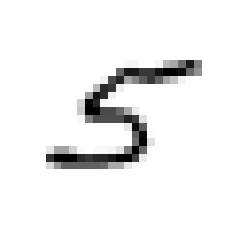

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
def show_digit_image(digit):
    digit_img = digit.reshape(28, 28)
    plt.imshow(digit_img, cmap=matplotlib.cm.binary)
    plt.axis("off")
    plt.show()
digit = X[3007]
show_digit_image(digit)

In [4]:
def plot_digits(X, image_per_row=5):
    plt.figure(figsize=(image_per_row, image_per_row))
    for i in range(0, image_per_row*image_per_row):
        plt.subplot(image_per_row, image_per_row, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=matplotlib.cm.binary)
        plt.axis("off")

## Get Train and Test Sets

In [5]:
# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(X, test_size=0.1428571, random_state=42, shuffle=True) # 1000 and 6000 data
# y_train, y_test = train_test_split(y, test_size=0.1428571, random_state=42, shuffle=True)
import numpy as np
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Start Just from 5

In [6]:

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

## We can add PCA to MNIST 
This reduce dimensionality of data set.


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
X_train_reduced = pca.transform(X_train)

In [9]:
X_train.shape

(60000, 784)

In [10]:
X_train_reduced.shape

(60000, 154)

In [11]:
np.sum(pca.explained_variance_ratio_)

0.9501960192613034

You see it reduced dimensions to 154 from 784. It is agile!!

We can also use inverse transform to get back that features again. 

In [12]:
X_train_semi_org = pca.inverse_transform(X_train_reduced)

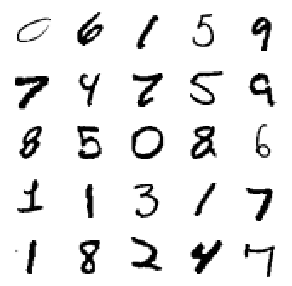

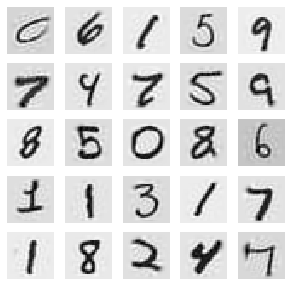

In [13]:
plot_digits(X_train[:25], image_per_row=5)
plot_digits(X_train_semi_org[:25], image_per_row=5)

Now let compare train time of these two train sets. 

In [14]:
from sklearn.linear_model import SGDClassifier
import time
start = time.time()

sgd = SGDClassifier(random_state=42,n_jobs=-1)
sgd.fit(X_train, y_train_5)

end = time.time()
print("Time of sgd without pca is : ", end - start)

Time of sgd without pca is :  24.51701307296753


**NOTE** : When I test this sets as int 32 or int 8 types it didn't work with this model!

In [15]:
sgd.predict([digit])

array([ True])

In [16]:
start = time.time()

sgd = SGDClassifier(random_state=42,n_jobs=-1)
sgd.fit(X_train_semi_org, y_train_5)

end = time.time()
print("Time of sgd with pca is : ", end - start)

Time of sgd with pca is :  42.665401220321655


In [17]:
sgd.predict([digit])

array([ True])

__Well you see time reduced rapidly!__

## Checking Cross-Validation with `Accuracy` Method

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

In [19]:
scores

array([0.96105, 0.9586 , 0.96655])

### But Wait!

In [20]:
from sklearn.base import BaseEstimator
class DumbClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        

In [21]:
dumb_model = DumbClassifier()
cross_val_score(dumb_model, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9127 , 0.90895, 0.9073 ])

You see we have over 90% accuracy here :D

## Now Lets Check `Confusion Matrix`

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53909,   670],
       [ 1606,  3815]])

Each row represent an **actual** class and each column represent a **predicted** class.

| TN | FP |
|----|----|
| FN | TP |

## Recall and Precision

In [24]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_train_5, y_train_pred)
precision = precision_score(y_train_5, y_train_pred)

In [25]:
recall

0.7037446965504519

In [26]:
precision

0.850613154960981

### What about F1 ?

In [27]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
f1

0.7702402584292348

In fact F1 is a kind of cross function and set more weight to low value. It depends on question to select recall or precision. And if both of them are important you can use f1 harmunic mean value.

**Precision/Recall Trade Off** : Increasing precision reduce recall.

### Seeing trade of between Precision and Recall

In [28]:
y_score = sgd.decision_function([digit])

In [29]:
y_score

array([2216.38623939])

In [30]:
threshold = 0 # default threshold in SGDClassifier
y_digit_prediction = (y_score > threshold)
y_digit_prediction

array([ True])

In [31]:
y_score = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_5, y_score)

In [33]:
def show_plot_precision_recall(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "r-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.show()

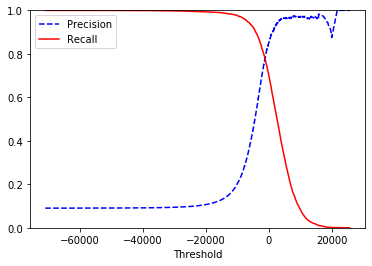

In [34]:
show_plot_precision_recall(precision, recall, thresholds)

In [35]:
def show_plot_precision_aganist_recall(precision, recall):
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

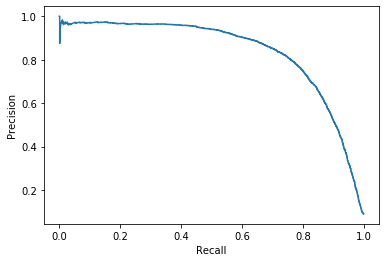

In [36]:
show_plot_precision_aganist_recall(precision, recall)

In [37]:
y_train_pred_90 = (y_score > 3000)
precision_score(y_train_5, y_train_pred_90)

0.9458364038319823

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.47352886921232246

When precision is good and recall not it doesn't means that this classifier is good clasifier.

## The ROC Curve

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

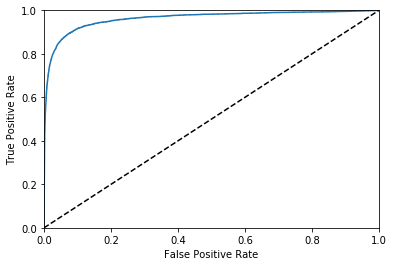

In [40]:
def show_fpr_tpr(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.ylabel("True Positive Rate")
    plt.show()
show_fpr_tpr(fpr, tpr)

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_score)

0.9624045449888815

## Let use Random Forest


In [42]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_model, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)

In [43]:
y_probs_forest[:, -1]


array([0.8, 0. , 0. , ..., 0. , 0. , 0. ])

In [44]:
y_score_forest = y_probs_forest[:, -1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_score_forest)


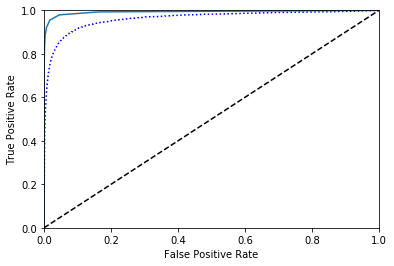

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
show_fpr_tpr(fpr_forest, tpr_forest)


##### As you see roc_curve for random forest is more

In [46]:
roc_auc_score(y_train_5, y_score_forest)

0.9928646641646385

Let compute recall and precision for this estimation method

In [47]:
y_pred_forest = cross_val_predict(forest_model, X_train, y_train_5, cv=3, n_jobs=-1)

In [48]:
recall = recall_score(y_train_5, y_pred_forest)
precision = precision_score(y_train_5, y_pred_forest)
print(f"Recall is {recall} and Precision is {precision}")

Recall is 0.8273381294964028 and Precision is 0.9852811950790861


### What is one-versus-all (OvA Strategy) ?
It means we have for every prediction a predictor against all others
### What is one-versus-one (OvO Strategy) ?
It means we have for every pair of things that we want to predict have a predictor

## Try SGD for multiclass classification


In [49]:
sgd.fit(X_train, y_train)
sgd.predict([digit])

array(['5'], dtype='<U1')

If we use decision function it reutrns 10 scores instead of 1 score


In [50]:
sgd.decision_function([digit])

array([[ -8579.43222495, -18481.72721298,  -6904.80434543,
         -3267.51747664,  -1461.93563807,   2986.36290677,
        -15533.58360603,  -8774.63847461,  -2141.68970858,
         -7253.77951756]])

## How to force OvO or OvA ?

In [51]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [52]:
ovo_clf.predict([digit])

array(['5'], dtype=object)

In [53]:
len(ovo_clf.estimators_)

45

### What about Random Forest ?

In [54]:
forest_model.fit(X_train, y_train)
forest_model.predict([digit])

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array(['5'], dtype=object)

Forest Model doesn't need specify ovo or ova

In [55]:
forest_model.predict_proba([digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [56]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([0.86477704, 0.87179359, 0.87878182])

## With StandardScaler we can get better results 

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90161968, 0.90334517, 0.90728609])

**Note** I used forest model before and after standard scaler but it did not change in accuracy. I think it doesn't impact on this method of classificatio.

## Let See Errors
For this we first see the errors with confusion matrix. reading numbers is not easy so we change it to an image :D

In [58]:
y_train_predict = cross_val_predict(sgd, X_train_scaled, y_train, cv=3, n_jobs=-1)

In [59]:
conf_matrix = confusion_matrix(y_train, y_train_predict)
conf_matrix

array([[5612,    0,   18,    8,    9,   48,   34,    5,  188,    1],
       [   1, 6427,   43,   23,    3,   44,    4,    8,  177,   12],
       [  29,   28, 5288,   92,   67,   26,   69,   40,  307,   12],
       [  30,   20,  115, 5270,    3,  227,   22,   45,  332,   67],
       [  14,   15,   45,   13, 5252,    9,   37,   21,  266,  170],
       [  31,   19,   28,  160,   49, 4532,   78,   20,  437,   67],
       [  25,   17,   49,    3,   42,  103, 5564,    5,  110,    0],
       [  21,   12,   55,   28,   47,   11,    3, 5729,  128,  231],
       [  19,   63,   45,   94,    5,  138,   33,   11, 5395,   48],
       [  25,   20,   34,   61,  125,   40,    1,  177,  290, 5176]])

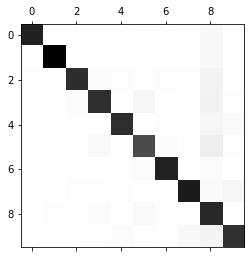

In [60]:
plt.matshow(conf_matrix, cmap=matplotlib.cm.binary)

In [61]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)

In [62]:
norm_conf_matrix = conf_matrix / row_sums

In [63]:
norm_conf_matrix

array([[9.47492825e-01, 0.00000000e+00, 3.03900051e-03, 1.35066689e-03,
        1.51950025e-03, 8.10400135e-03, 5.74033429e-03, 8.44166807e-04,
        3.17406720e-02, 1.68833361e-04],
       [1.48323939e-04, 9.53277959e-01, 6.37792940e-03, 3.41145061e-03,
        4.44971818e-04, 6.52625334e-03, 5.93295758e-04, 1.18659152e-03,
        2.62533373e-02, 1.77988727e-03],
       [4.86740517e-03, 4.69956361e-03, 8.87546156e-01, 1.54414233e-02,
        1.12453844e-02, 4.36388050e-03, 1.15810675e-02, 6.71366230e-03,
        5.15273582e-02, 2.01409869e-03],
       [4.89316588e-03, 3.26211059e-03, 1.87571359e-02, 8.59566139e-01,
        4.89316588e-04, 3.70249551e-02, 3.58832164e-03, 7.33974882e-03,
        5.41510357e-02, 1.09280705e-02],
       [2.39643958e-03, 2.56761383e-03, 7.70284149e-03, 2.22526532e-03,
        8.99007189e-01, 1.54056830e-03, 6.33344745e-03, 3.59465936e-03,
        4.55323519e-02, 2.90996234e-02],
       [5.71850212e-03, 3.50488840e-03, 5.16509869e-03, 2.95148497e-02,
   

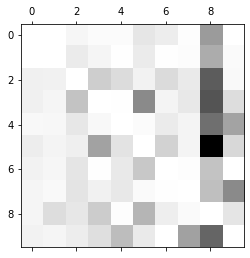

In [64]:
np.fill_diagonal(norm_conf_matrix, 0) # It means set zero in قطر
plt.matshow(norm_conf_matrix, cmap=matplotlib.cm.binary)

## Ploting predictions 

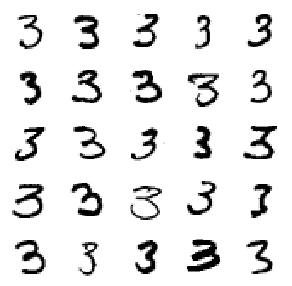

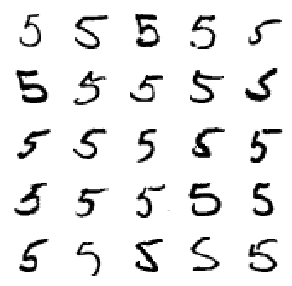

In [65]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_predict == cl_b)]

plot_digits(X_aa[:25], image_per_row=5)
plot_digits(X_bb[:25], image_per_row=5)
plt.show()

## Multi Label Classification

In [66]:
from sklearn.neighbors import KNeighborsClassifier
y_train_larg = (y_train >= '7')
y_train_odd = (y_train.astype(np.int64) % 2 == 1)
y_multi_label = np.c_[y_train_larg, y_train_odd]
y_multi_label

array([[False, False],
       [False, False],
       [False,  True],
       ...,
       [ True, False],
       [False, False],
       [False, False]])

In [67]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multi_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [68]:
knn_clf.predict([digit])

array([[False,  True]])

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multi_label, cv=3, n_jobs=-1)

In [72]:
# f1_score(y_multi_label, y_train_knn_pred)

## Multi Output Classification

In [73]:
import numpy.random as rnd
noise_train = rnd.randint(0, 100, (len(X_train), 784))
noise_test = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

In [74]:
knn_clf.fit(X_train_mod, y_train_mod)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

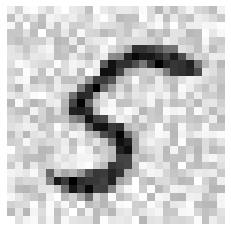

In [75]:
show_digit_image(X_test_mod[3007])

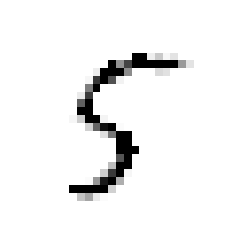

In [76]:
clean_digit = knn_clf.predict([X_test_mod[3007]])
show_digit_image(clean_digit)

## end